In [68]:
import pandas as pd
import json
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [69]:
# Load your dataset
data = pd.read_csv("C:/Users/user/Desktop/steam_5_ids_1000_reviews.csv")

In [70]:
# Preprocess the author column to ensure correct JSON formatting
data['author'] = data['author'].apply(lambda x: x.replace("'", "\""))

# Handle cases where JSON-like data might not be correctly formatted
def parse_json(x):
    try:
        return json.loads(x)
    except json.JSONDecodeError:
        return None

# Apply the parsing function to the author column
data['author'] = data['author'].apply(parse_json)

# Split the JSON-like data into separate columns
data['steamid'] = data['author'].apply(lambda x: x.get('steamid', None) if x else None)
data['num_games_owned'] = data['author'].apply(lambda x: x.get('num_games_owned', None) if x else None)
data['num_reviews'] = data['author'].apply(lambda x: x.get('num_reviews', None) if x else None)
data['playtime_forever'] = data['author'].apply(lambda x: x.get('playtime_forever', None) if x else None)
data['playtime_last_two_weeks'] = data['author'].apply(lambda x: x.get('playtime_last_two_weeks', None) if x else None)
data['playtime_at_review'] = data['author'].apply(lambda x: x.get('playtime_at_review', None) if x else None)
data['last_played'] = data['author'].apply(lambda x: x.get('last_played', None) if x else None)

# Drop the original "author" column
data.drop(columns=['author'], inplace=True)

# Now, you have separate columns for each attribute of the author
print(data.head())


   Unnamed: 0  recommendationid language  \
0           0         158456131  english   
1           1         158015300  english   
2           2         157891698  english   
3           3         158229926  english   
4           4         158253018  english   

                                              review  timestamp_created  \
0  The only co-op game where you are scared of yo...         1708099453   
1  Worked so hard to save Super-Earth, only to be...         1707586995   
2  Thank you Jimmy525521,\nI will never forget th...         1707441205   
3  During the tutorial, I threw a grenade into a ...         1707832256   
4      I'm from Buenos Aires and I say kill 'em all!         1707853843   

   timestamp_updated  voted_up  votes_up  votes_funny  weighted_vote_score  \
0         1708099453      True      2711         1067             0.972446   
1         1707586995      True      3477         1111             0.972198   
2         1707441205      True      4733         1

In [71]:
features = ['voted_up', 'votes_up', 'votes_funny', 'weighted_vote_score', 
            'comment_count', 'steam_purchase', 'received_for_free', 'written_during_early_access', 
            'hidden_in_steam_china', 'app_id', 'num_games_owned', 'num_reviews', 'playtime_forever', 
           'playtime_last_two_weeks', 'playtime_at_review']

X = data[features]

In [72]:
nan_columns = X.isna().any()
print("Columns containing NaN values:")
print(nan_columns[nan_columns].index.tolist())

Columns containing NaN values:
['playtime_at_review']


In [73]:
X = X.copy()
X.dropna(subset=['playtime_at_review'], inplace=True)

In [74]:
numeric_features = ['votes_up', 'votes_funny', 'weighted_vote_score', 'comment_count', 'app_id', 
                    'num_games_owned', 'num_reviews', 'playtime_forever', 'playtime_last_two_weeks', 'playtime_at_review']
categorical_features = ['voted_up', 'steam_purchase', 'received_for_free', 
                        'written_during_early_access', 'hidden_in_steam_china']

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [75]:
# Calculate the Elbow Score
def calculate_wcss(X):
    wcss = []
    for n_clusters in range(1, 11):
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('kmeans', KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0))
        ])
        pipeline.fit(X)
        wcss.append(pipeline['kmeans'].inertia_)
    return wcss

# Plot the Elbow Method graph
def plot_elbow(wcss):
    plt.plot(range(1, 11), wcss)
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

# Calculate Silhouette Score
def calculate_silhouette_score(X, n_clusters):
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('kmeans', KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0))
    ])
    pipeline.fit(X)
    labels = pipeline['kmeans'].labels_
    silhouette_avg = silhouette_score(X, labels)
    return silhouette_avg

# Find optimal number of clusters using Silhouette Score
def find_optimal_clusters(X):
    silhouette_scores = []
    for n_clusters in range(2, 11):
        silhouette_avg = calculate_silhouette_score(X, n_clusters)
        silhouette_scores.append(silhouette_avg)

    optimal_clusters = silhouette_scores.index(max(silhouette_scores)) + 2
    return optimal_clusters

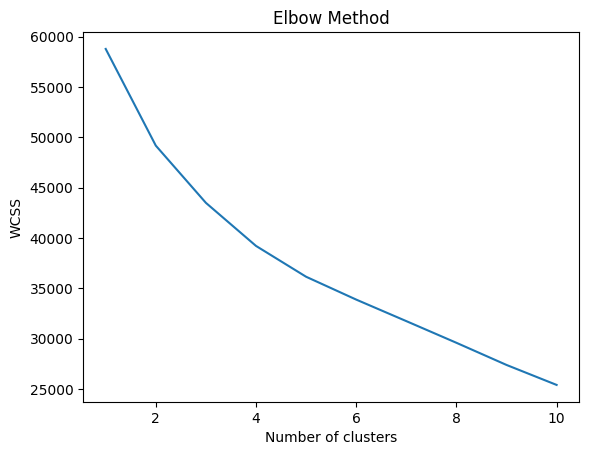

Optimal number of clusters using Silhouette Score: 2


In [76]:
# Calculate WCSS for Elbow Method
wcss = calculate_wcss(X)
plot_elbow(wcss)

# Find optimal number of clusters using Silhouette Score
optimal_clusters = find_optimal_clusters(X)
print("Optimal number of clusters using Silhouette Score:", optimal_clusters)

In [77]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('kmeans', KMeans(n_clusters=2)) 
])

# Fit the pipeline to the data
pipeline.fit(X)

# Add cluster labels to the original dataset
X['cluster'] = pipeline['kmeans'].labels_

# Analyze clusters
cluster_analysis = X.groupby('cluster').mean()

print(cluster_analysis)

         voted_up    votes_up  votes_funny  weighted_vote_score  \
cluster                                                           
0        0.695828   65.172134    11.951802             0.628081   
1        0.703953  581.001976   289.833992             0.813542   

         comment_count  steam_purchase  received_for_free  \
cluster                                                     
0             1.621709        0.814905           0.012556   
1            18.950593        0.366798           0.037154   

         written_during_early_access  hidden_in_steam_china         app_id  \
cluster                                                                      
0                           0.388416               0.664237  697136.739571   
1                           0.020158               0.169565  123228.782609   

         num_games_owned  num_reviews  playtime_forever  \
cluster                                                   
0             237.950587    27.642365      15337.855002